In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def c_FeSCN2p(Y, Z, B1, I=None, z_rhs=(2,), z_lhs=(3,-1)):
    if I is None:
        I = Z + 6*Y
    if I is not 0:
        A = 0.509
        z_factor = sum([z**2 for z in z_rhs] + [-z**2 for z in z_lhs])
        B1 = B1 * 10**(A*z_factor*I**0.5)
    c0 = (Y+Z+1.0/B1)
    return c0/2 - (c0**2/4 - Y*Z)**0.5

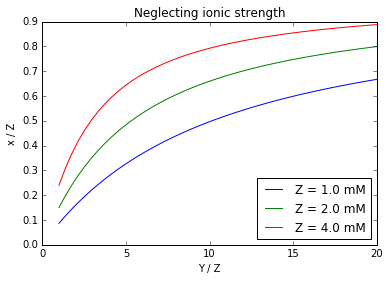

In [3]:
def plot(Z, I=None, excess=None):
    if excess is None:
        excess = np.linspace(1, 20)
    Y = Z*excess
    plt.plot(Y/Z, c_FeSCN2p(Y, Z, 10**2.016, I)/Z, label='Z = {} mM'.format(Z*1000))
plot(1e-3, I=0)
plot(2e-3, I=0)
plot(4e-3, I=0)
plt.title('Neglecting ionic strength')
plt.xlabel('Y / Z')
plt.ylabel('x / Z')
_ = plt.legend(loc='best')

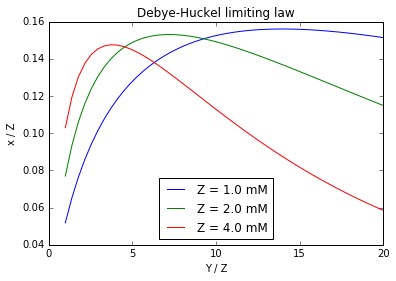

In [4]:
plot(1e-3)
plot(2e-3)
plot(4e-3)
plt.title('Debye-Huckel limiting law')
plt.xlabel('Y / Z')
plt.ylabel('x / Z')
_ = plt.legend(loc='best')

In [5]:
def rho_water(T=298.15):
    """ VSMOW """
    T0 = 273.15 # K
    a = (-3.983035,  # K
        301.797, 
        522528.9, # K**2
        69.34881, # K
        999.974950) # kg / m**3
    t = T - T0
    return a[4]*(1-((t + a[0])**2*(t + a[1]))/(a[2]*(t + a[3])))

In [6]:
abs(rho_water(273.15 + 0) - 999.8395) < 0.004
abs(rho_water(273.15 + 4) - 999.9720) < 0.003
abs(rho_water(273.15 + 10) - 999.7026) < 0.0003
abs(rho_water(273.15 + 15) - 999.1026) < 0.0001
abs(rho_water(273.15 + 20) - 998.2071) < 0.0005
abs(rho_water(273.15 + 22) - 997.7735) < 0.0007
abs(rho_water(273.15 + 25) - 997.0479) < 0.0009
abs(rho_water(273.15 + 30) - 995.6502) < 0.0016
abs(rho_water(273.15 + 40) - 992.2) < 0.02

True

In [7]:
def eps_water(T=298.15, P=1.0):
    """
    Permitivity of water according to the parametrization by Bradley and Pitzer
    (empirical parametrization)
    
    Parameters
    ----------
    T: float
        Temperature in Kelvin
    P: float
        Pressure in bar
        
    References
    ----------
    - Bradley, D.J.; Pitzer, K.S. `Thermodynamics of electrolytes. 12. Dielectric
        properties of water and Debye--Hueckel parameters to 350/sup 0/C and 1 kbar`,
        J. Phys. Chem.; Journal Volume 83 (12) (1979), pp. 1599-1603
        http://pubs.acs.org/doi/abs/10.1021/j100475a009
        DOI: 10.1021/j100475a009
    """
    from math import exp
    from math import log as ln
    U = [0,  3.4279e2, -5.0866e-3, 9.4690e-7, -2.0525, 3.1159e3, 
        -1.8289e2, -8.0325e3, 4.2142e6, 2.1417]
    B  = U[7] + U[8]/T + U[9]*T
    C  = U[4] + U[5]/(U[6]+T)
    eps1000 = U[1]*exp(U[2]*T+U[3]*T**2)
    return eps1000 + C*ln((B+P)/(B+1000.0))

In [8]:
eps_water(298.15)

78.38436874203077

In [9]:
def dh_A(T, eps):
    return 1.82e6*(eps*T)**(-3./2)

def dhe_B(T, eps):
    return 50.3*(eps*T)**(-1./2)

def dhl_log10_gamma(I, z, A):
    """ log10 of activity coefficient according to limiting law in Debye-Hückel theory """
    return -A*z**2*I**0.5

def dhe_log10_gamma(I, z, a, A, B):
    """ log10 of activity coefficient according to extended Debye-Hückel theory """
    return -A*z**2*I**0.5/(1+B*a*I**0.5)

In [10]:
def dhl_activity_product(I, z_lhs, z_rhs, T, eps):
    """ Debye-Huckel limiting law """
    A = dh_A(T, eps)
    tot = 0
    for z in z_lhs:
        tot -= dhl_log10_gamma(I, z, A)
    for z in z_rhs:
        tot += dhl_log10_gamma(I, z, A)    
    return 10**tot

def dhe_activity_product(I, z_lhs, z_rhs, T, eps, a_lhs, a_rhs):
    """ Debye-Huckel extended law """
    A = dh_A(T, eps)
    B = dhe_B(T, eps)
    tot = 0
    for z, a in zip(z_lhs, a_lhs):
        tot -= dhe_log10_gamma(I, z, a, A, B)
    for z, a in zip(z_rhs, a_rhs):
        tot += dhe_log10_gamma(I, z, a, A, B)    
    return 10**tot

In [11]:
a_Fe3p = 0.9  # nm
a_SCNm = 0.35  # nm
a_FeSCN2p = 0.6  # nm  - assumed same as Fe2+

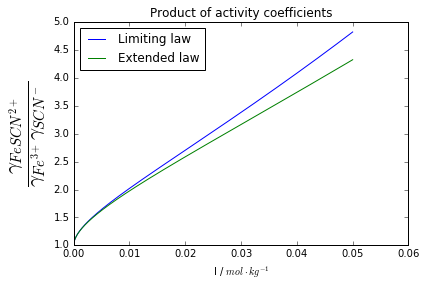

In [12]:
I = np.linspace(0, .05, 1000)
plt.plot(I, dhl_activity_product(I, (3, -1), (2,), 298.15, eps=eps_water(298.15)), label='Limiting law')
plt.plot(I, dhe_activity_product(I, (3, -1), (2,), 298.15, eps_water(298.15), 
         (a_Fe3p, a_SCNm), (a_FeSCN2p,)), label='Extended law')
plt.title('Product of activity coefficients')
plt.xlabel('I / $mol \cdot kg^{-1}$')
plt.ylabel(r'$\frac{\gamma_{FeSCN^{2+}}}{\gamma_{Fe^{3+}}\gamma_{SCN^-}}$', fontsize=30)
#plt.ylabel('$\frac{\gamma}{\gamma\gamma}$')
_ = plt.legend(loc='best')

In [13]:
(a_Fe3p, a_SCNm), (a_FeSCN2p,)

((0.9, 0.35), (0.6,))

In [14]:
def ionic_strength(molalities, charges):
    tot = 0
    for b, z in zip(molalities, charges):
        tot += b*z**2
    return 0.5*tot

In [15]:
def equilibrium_quotient(c_lhs, c_rhs):
    tot = 1
    for c in c_lhs:
        tot /= c
    for c in c_rhs:
        tot *= c
    return tot

In [16]:
def equilibrium_residual(chi, K, stoich, c0, T, z=None, a=None, I0=0.0, rho=1.0,
                         activity_product=None):
    c = c0 + chi*stoich
    c_lhs, c_rhs = [], []
    if z is not None:
        z_lhs, z_rhs = [], []
    if a is not None:
        a_lhs, a_rhs = [], []
    for i, coeff in enumerate(stoich):
        if coeff > 0:
            c_rhs.append(c[i])
            if z is not None:
                z_rhs.append(z[i])
            if a is not None:
                a_rhs.append(a[i])
        elif coeff < 0:
            c_lhs.append(c[i])
            if z is not None:
                z_lhs.append(z[i])
            if a is not None:
                a_lhs.append(a[i])
    Q = equilibrium_quotient(c_lhs, c_rhs)
    if z is not None:
        if activity_product is None:
            args = ()
            if a is None:
                activity_product = dhl_activity_product
            else:
                activity_product = dhe_activity_product
                args =  a_lhs, a_rhs
        ap = activity_product(I0 + ionic_strength(c/rho, z),
                     z_lhs, z_rhs, T, eps_water(T), *args)
        Q *= ap
    return K - Q

In [17]:
K = 10**2.016
stoich = (1, -1, -1)  # FeSCN2+, Fe3+, SCN-
z = (2, 3, -1)
a = (a_FeSCN2p, a_Fe3p, a_SCNm)
c0 = (0.0, 4e-3, 2e-3)
T = 298.15

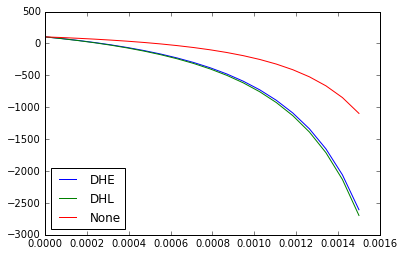

In [18]:
chi = np.linspace(0, 1.5e-3, 20)
plt.plot(chi, [equilibrium_residual(x, K, np.array(stoich), np.array(c0), T, z, a) for x in chi], label='DHE')
plt.plot(chi, [equilibrium_residual(x, K, np.array(stoich), np.array(c0), T, z, None) for x in chi], label='DHL')
plt.plot(chi, [equilibrium_residual(x, K, np.array(stoich), np.array(c0), T, None, None) for x in chi], label='None')
_ = plt.legend(loc='best')

In [19]:
def get_chi_interval(stoich, c0):
    limits = c0/stoich
    if np.any(limits < 0):
        upper = -np.max(limits[np.argwhere(limits < 0)])
    else:
        upper = 0
        
    if np.any(limits > 0):
        lower = -np.min(limits[np.argwhere(limits > 0)])
    else:
        lower = 0
        
    if lower is 0 and upper is 0:
        raise ValueError("0-interval")
    else:
        return lower, upper

In [20]:
get_chi_interval(np.array(stoich), np.array(c0))

(0, 0.002)

In [21]:
from scipy.optimize import brentq

def solve_equilibrium(K, stoich, c0, T, z=None, a=None, I0=0.0, delta=1e-16):
    lower, upper = get_chi_interval(np.array(stoich), np.array(c0))
    chi = brentq(equilibrium_residual, lower+delta, upper-delta, (K, np.array(stoich), np.array(c0), T, z, a, I0))
    return np.array(c0) + chi*np.array(stoich)

In [22]:
c0 = (0, 4e-3, 2e-3)
c0

(0, 0.004, 0.002)

In [23]:
solve_equilibrium(K, np.array(stoich), np.array(c0), T, z, a)

array([ 0.00026991,  0.00373009,  0.00173009])

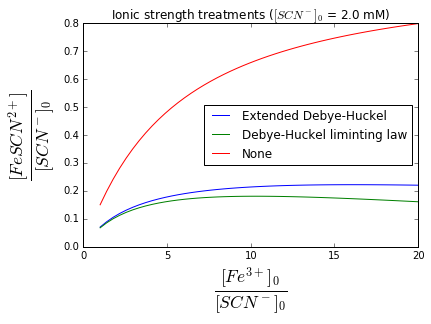

In [24]:
def yield_vs_excess(excess, scn0, T, z=None, a=None, I0=0.0):
    c = []
    for e in excess:
        c0 = (0, e*scn0, scn0)
        c.append(solve_equilibrium(K, stoich, c0, T, z, a, I0=I0))
    c = np.array(c)
    return c[:, 0]/scn0

excess = np.linspace(1, 20)
scn0 = 2e-3
I0 = 10e-3

plt.plot(excess, yield_vs_excess(excess, scn0, T, z, a, I0), label='Extended Debye-Huckel')
plt.plot(excess, yield_vs_excess(excess, scn0, T, z, None, I0), label='Debye-Huckel liminting law')
plt.plot(excess, yield_vs_excess(excess, scn0, T, None, None, I0), label='None')
plt.legend(loc='best')
plt.xlabel('$\\frac{[Fe^{3+}]_0}{[SCN^-]_0}$', fontsize=25)
plt.ylabel('$\\frac{[FeSCN^{2+}]}{[SCN^-]_0}$', fontsize=25)
_ = plt.title('Ionic strength treatments ($[SCN^-]_0$ = {} mM)'.format(scn0*1000))

We need $\Delta H$ and $\Delta S$ (or just $\Delta G$) for our complex formation
reaction. There is some data available from:
    [M. W. Lister and D. E. Rivington: SOME MEASUREMENTS ON THE IRON (111)–THIOCYANATE SYSTEM IN AQUEOUS SOLUTION
    *Canadian Journal of Chemistry*, 1955, 33(10): 1572-1590](dx.doi.org/10.1139/v55-192)

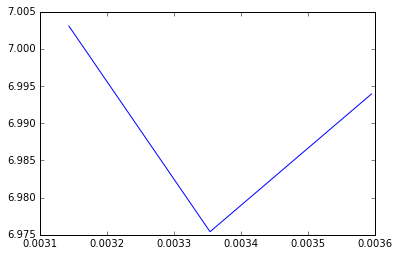

In [25]:
# Lister & Rivington 1955 p. 1587
T_lister = 273.15 + np.array([5, 25, 45])
K_lister = np.array([1090, 1070, 1100])  # Corrected for ionic strength
plt.plot(1/T_lister, np.log(K_lister), label='Lister & Rivington 1955')

The details of the ionic strength correction is a bit vague in the article. Let's see if we can apply the extended Debye Huckel equation:

DeltaG = 1.94608487073 +/- 0.140785589793 kJ/mol


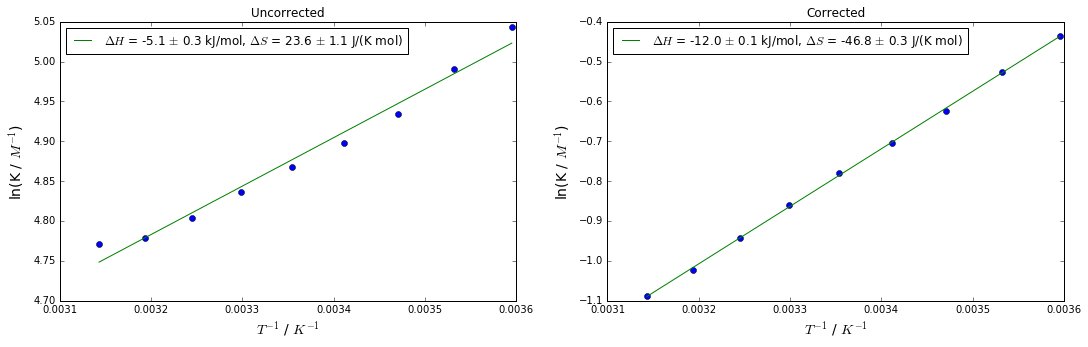

In [26]:
# Lister & Rivington p. 1586
R = 8.314511
Tdata = 273.15 + np.array([5, 10, 15, 20, 25, 30, 35, 40, 45])
Kobs = np.array([155.0, 147, 139, 134, 130, 126, 122, 119, 118])  # not corrected for ionic strength
I_lister = 1.2
Ktrue = []

for idx, temp in enumerate(Tdata):
    Ktrue.append(Kobs[idx] / dhe_activity_product(I_lister, (3, -1), (2,), temp, eps_water(temp), (a_Fe3p, a_SCNm), (a_FeSCN2p,)))

plt.figure(figsize=(18,5))
for idx, (title, Kvals) in enumerate(zip(['Uncorrected', 'Corrected'], [Kobs, Ktrue])):
    plt.subplot(1, 2, idx+1)
    p, cov = np.polyfit(1/Tdata, np.log(Kvals), 1, cov=True)
    deltaH, deltaS = p[0]*-R, p[1]*R
    deltaHs = cov[0, 0]**0.5 * R
    deltaSs = cov[1, 1]**0.5 * R
    plt.plot(1/Tdata, np.log(Kvals), 'o')
    fmtstr = ('$\Delta H$ = {0:.1f} $\pm$ {1:.1f} kJ/mol, '
              '$\Delta S$ = {2:.1f} $\pm$ {3:.1f} J/(K mol)')
    lbl = fmtstr.format(1e-3*deltaH, 1e-3*deltaHs, deltaS, deltaSs)
    plt.plot(1/Tdata, np.polyval(p, 1/Tdata), label=lbl)
    plt.ylabel('ln(K / $M^{-1}$)', fontsize=14)
    plt.xlabel('$T^{-1}$ / $K^{-1}$', fontsize=14)
    plt.legend(loc='best')
    plt.title(title)
print('DeltaG = {} +/- {} kJ/mol'.format(1e-3*(deltaH - 298.15*deltaS), 
                                         1e-3*(deltaHs**2 + (298.15*deltaSs)**2)**0.5))

The obtained value agrees reasonalby well with $\Delta H = -4.42 \pm 0.52$ kJ/mol reported by [J.O. Hill and S. Korce, A thermometric titrimetry study of Fe3+/SCN− and Ag+/SCN− systems, Thermochimica Acta, 154 (1989) 49-55.](http://dx.doi.org/10.1016/0040-6031%2889%2987117-5)

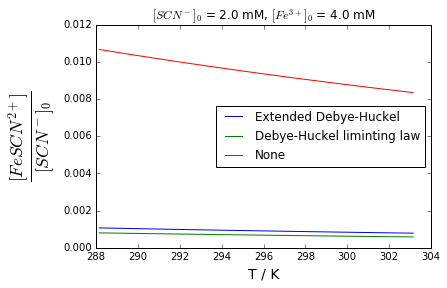

In [27]:
from math import exp
def yield_vs_T(temperatures, c0, deltaH, deltaS, z=None, a=None, I0=0.0):
    c = []
    R = 8.314511
    for T in temperatures:
        K = exp(deltaS/R - deltaH/(R*T))
        c.append(solve_equilibrium(K, stoich, c0, T, z, a, I0=I0))
    c = np.array(c)
    return c[:, 0]/c0[2]

Tplot = 273.15 + np.linspace(15, 30)
cplot = (0.0, 20e-3, 2e-3)
Iplot = 50e-3

plt.plot(Tplot, yield_vs_T(Tplot, cplot, deltaH, deltaS, z, a, Iplot), label='Extended Debye-Huckel')
plt.plot(Tplot, yield_vs_T(Tplot, cplot, deltaH, deltaS, z, None, Iplot), label='Debye-Huckel liminting law')
plt.plot(Tplot, yield_vs_T(Tplot, cplot, deltaH, deltaS, None, None, Iplot), label='None')
plt.legend(loc='best')
plt.xlabel('T / K', fontsize=14)
plt.ylabel('$\\frac{[FeSCN^{2+}]}{[SCN^-]_0}$', fontsize=25)
fmtstr = '$[SCN^-]_0$ = {} mM, $[Fe^{{3+}}]_0$ = {} mM'
_ = plt.title(fmtstr.format(c0[2]*1000, c0[1]*1000))
